In [ ]:
! pip install pandas_ta --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [134]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

С помощью специальной библиотеки (yfinancd) стянем данные с биржи.

In [135]:
start_date = dt.datetime(2018, 1, 1)

end_date = dt.datetime.now( )

data = yf.download('TON11419-USD', start=start_date, end=end_date)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-27,0.519893,0.687477,0.498175,0.686748,0.686748,573566
2021-08-28,0.686766,0.691065,0.606474,0.640526,0.640526,250158
2021-08-29,0.640724,0.648018,0.527709,0.548201,0.548201,188295
2021-08-30,0.548234,0.915924,0.547050,0.868268,0.868268,763243
2021-08-31,0.869410,1.132030,0.795093,1.034563,1.034563,1802341
...,...,...,...,...,...,...
2024-08-26,5.786217,5.815028,5.082398,5.115549,5.115549,991748884
2024-08-27,5.115549,5.627440,5.115549,5.453750,5.453750,703687795
2024-08-28,5.453750,5.887649,5.151222,5.523499,5.523499,1434235826


Добавим технические индикаторы, такие как индекс относительной силы (rsi) и экспоненциально сглаженные скользящие средние для диапазона 20 и 50 точек (ema_20, ema_50)

In [136]:
data['rsi'] = ta.rsi(data.Close, length=14)
data ['ema_20'] = ta.ema(data.Close, length=20)
data ['ema_50'] = ta.ema(data.Close, length=50)

Выполним предобработку на очистку отсутсвующих значений и масштабирование данных

In [137]:
# drop NaN
data = data.dropna(axis=0)
data.isna().value_counts ()

,,,,,,,,,count
Open,High,Low,Close,Adj Close,Volume,rsi,ema_20,ema_50,
False,False,False,False,False,False,False,False,False,1051


In [138]:
y = data['Close']
del data['Close']
del data['Adj Close']
X = data

In [139]:
# scaling data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

Подготовим данные к обучению:

In [140]:
#разобьем данные на тренировочные, валидационные и тестовые
test_size = 0.3
len_x = len(X)
X_train = x_scaled[:int(len_x*(1-test_size)) ]
y_train = y_scaled[:int(len_x*(1-test_size))]
X_test = x_scaled[int(len_x*(1-test_size)):]
y_test = y_scaled[int(len_x*(1-test_size)):]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Разобьем выборки по пакетам и "временным" окнам, а также разделяем тренировочные данные на обучающие и валидационные

In [141]:
def split_window(X_loc, y_loc):
  window = 50
  batch_size = 32
  dataset_loc = keras.preprocessing.timeseries_dataset_from_array(
    X_loc,
    y_loc[window-1:], #сместим выходные данные, чтобы результатом предсказания было последний объект последовательности
    sequence_length=window,
    sampling_rate=1, #это смещение между данными в одном окне. 1 - идут подряд
    batch_size=batch_size,
  )
  return dataset_loc

In [142]:
dataset_train = split_window(X_train, y_train)

dataset_val = split_window(X_valid, y_valid)


for batch in dataset_train:
   inputs, targets = batch
   break


Построим модель

In [143]:
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out =LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 50, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

Обучим модель

In [144]:
checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=20, verbose=1)

tensorboard = TensorBoard(log_dir="./logs")

history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=500,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard
    ],
)

Epoch 1/500
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0247 - mae: 0.1260
Epoch 1: val_loss improved from inf to 0.00927, saving model to ./best-model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0235 - mae: 0.1222 - val_loss: 0.0093 - val_mae: 0.0835
Epoch 2/500
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0071 - mae: 0.0669
Epoch 2: val_loss improved from 0.00927 to 0.00774, saving model to ./best-model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0070 - mae: 0.0664 - val_loss: 0.0077 - val_mae: 0.0647
Epoch 3/500
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060 - mae: 0.0607
Epoch 3: val_loss improved from 0.00774 to 0.00671, saving model to ./best-model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059 - mae: 0.0604 - val_loss: 0.0067 - val_mae: 0.0645
Epoch 4/500
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055 - mae: 0.0582
Epoch 4: val_loss improved from 0.00671 to 0.00624, saving model to ./best-model.keras
17/17 ━━━━━━━━

Сохраним лучшую модель

In [145]:
best_model = load_model(checkpoint_path)
best_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 50, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,461 (60.40 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,308 (40.27 KB)

In [147]:
X_test.shape

(316, 7)

In [148]:
X_t = []
y_t = []
window = 50

for i in range(len(X_test)-window):
    X_t.append(X_test[i:i+window])
    y_t.append(y_test[i+window])

X_t = np.array(X_t)
y_t = np.array(y_t)

In [149]:
X_t.shape

(266, 50, 7)

In [151]:
predictions = best_model.predict(X_t)
inv_predictions = scaler.inverse_transform(predictions)
inv_real = scaler.inverse_transform(y_t.reshape(-1, 1))

predictions = inv_predictions.reshape(1, -1)[0]
real_values = inv_real

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


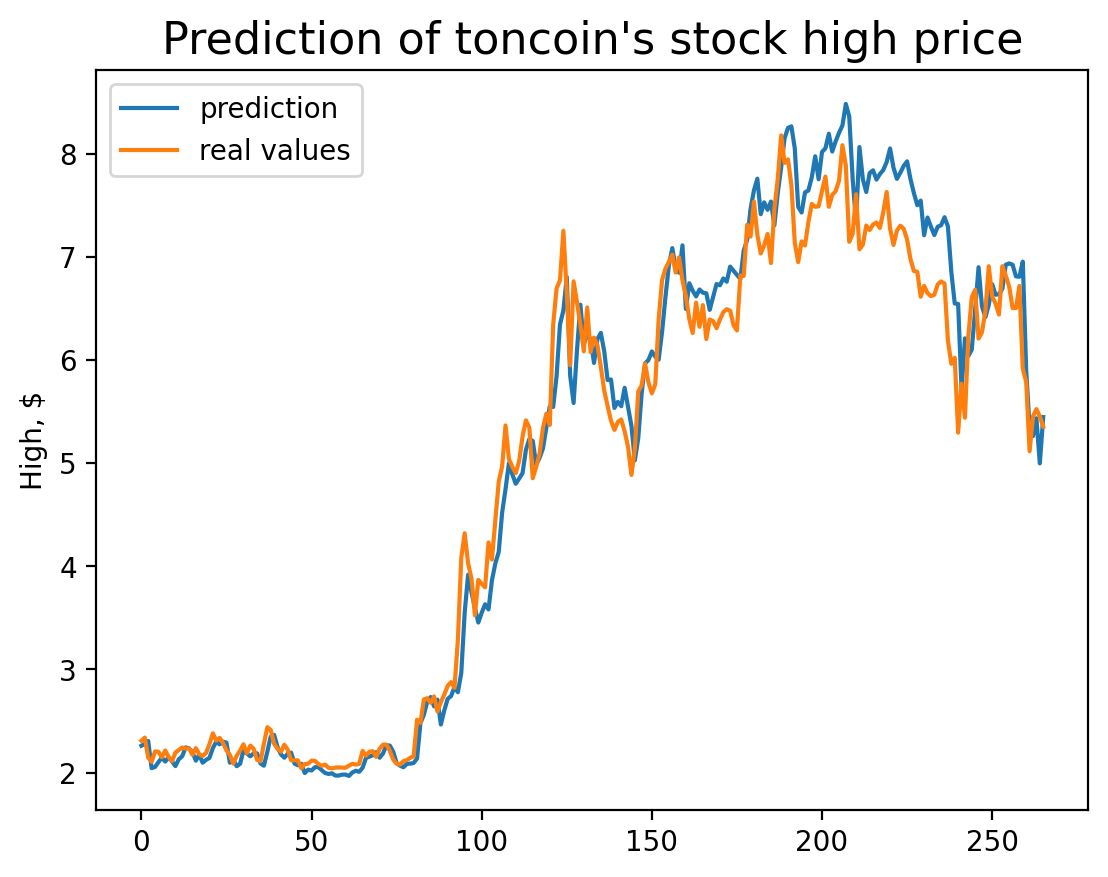

In [153]:
fig, ax = plt.subplots(1)
ax.plot(predictions, label='prediction')
ax.plot(real_values, label='real values')
ax.set_ylabel('High, $')
ax.set_title('Prediction of toncoin\'s stock high price', fontsize=16)
ax.legend()

fig.show()

In [165]:
r2_score(real_values, predictions)

0.9674528385928874

Видно, что данные предсказались очень качественно, о чем говорит коэффициент детерминации близкий к единице. В данной модели я добавил технические индексы, которые обычно используют трейдеры для анализа графиков котировок, для улучшения результата предсказания.

Кроме того данный код можно настроить на любую акцию, валюту, крипту, благодаря библиотеке yfinance.

In [ ]:
'''
def predict_today():
end_time = dt.datetime.now()
day_ago = end_time + dt. timedelta(days =- 50)
data_today = yf.download('BTC-USD', start=day_ago, end=end_time)
data_today ['rsi'] = ta.rsi(data_today.Close, length=15)
data_today ['ema_20'] = ta.ema(data_today.Close, length=20)
data_today ['ema_50'] = ta.ema(data_today.Close, length=50)
del data_today ['Close' ]
del data_today ['Adj Close']
data_today = data_today.iloc[-1]
print(data_today)
data_today_scaled = x_scaler.transform(data_today.values. reshape(1, -1))
print(data_today_scaled)
predict_today = model.predict(data_today_scaled)
inversed = y_scaler. inverse_transform(predict_today)
print(f'{end_time + dt.timedelta(days=1)} close price will be: {inversed}$')
'''